# 单摆动力学建模与数值积分（JAX实现）

## 问题描述

### 单摆物理模型
考虑一个简单的单摆系统，由质量为 $m$ 的质点通过长度为 $l$ 的无质量刚性杆悬挂在固定点构成。在重力场中，单摆的运动可以用角度 $\theta$ 来描述。

### 动力学方程
根据牛顿第二定律，单摆的运动方程为：
$$\ddot{\theta} = -\frac{g}{l}\sin(\theta)$$

其中：
- $\theta$：摆角（弧度）
- $\dot{\theta}$：角速度
- $\ddot{\theta}$：角加速度
- $g$：重力加速度（9.81 m/s²）
- $l$：摆长（1.0 m）

### 状态空间表示
定义状态向量 $\mathbf{x} = [\theta, \dot{\theta}]^T$，则系统的状态空间方程为：
$$\dot{\mathbf{x}} = \begin{bmatrix} \dot{\theta} \\ -\frac{g}{l}\sin(\theta) \end{bmatrix} = f(\mathbf{x})$$

## 数值积分方法

### 隐式欧拉法（Backward Euler Method）

对于微分方程 $\dot{\mathbf{x}} = f(\mathbf{x})$，隐式欧拉法的离散化公式为：
$$\mathbf{x}_{n+1} = \mathbf{x}_n + h \cdot f(\mathbf{x}_{n+1})$$

这是一个关于 $\mathbf{x}_{n+1}$ 的隐式方程，需要通过迭代方法求解。

### 求解方法

#### 1. 不动点迭代法（Fixed-Point Iteration）
将隐式方程重写为不动点形式：
$$\mathbf{x}_{n+1} = g(\mathbf{x}_{n+1}) = \mathbf{x}_n + h \cdot f(\mathbf{x}_{n+1})$$

迭代公式：
$$\mathbf{x}_{n+1}^{(k+1)} = \mathbf{x}_n + h \cdot f(\mathbf{x}_{n+1}^{(k)})$$

#### 2. 牛顿法（Newton's Method）
定义残差函数：
$$r(\mathbf{x}_{n+1}) = \mathbf{x}_n + h \cdot f(\mathbf{x}_{n+1}) - \mathbf{x}_{n+1}$$

牛顿迭代：
$$\mathbf{x}_{n+1}^{(k+1)} = \mathbf{x}_{n+1}^{(k)} - \left(\frac{\partial r}{\partial \mathbf{x}_{n+1}}\right)^{-1} r(\mathbf{x}_{n+1}^{(k)})$$

In [1]:
# 导入必要的库
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jit
import matplotlib.pyplot as plt
import numpy as np

# 设置JAX随机种子
key = jax.random.PRNGKey(42)

## JAX实现：单摆动力学函数

In [2]:
@jit
def pendulum_dynamics(x):
    """
    单摆动力学函数
    
    参数:
        x: 状态向量 [θ, θ̇]
    
    返回:
        状态导数 [θ̇, θ̈]
    """
    l = 1.0  # 摆长
    g = 9.81  # 重力加速度
    
    theta = x[0]      # 角度
    theta_dot = x[1]  # 角速度
    
    # 角加速度：θ̈ = -(g/l)*sin(θ)
    theta_ddot = -(g/l) * jnp.sin(theta)
    
    return jnp.array([theta_dot, theta_ddot])

## 隐式欧拉法实现：不动点迭代

In [3]:
def backward_euler_step_fixed_point(fun, x0, h, tol=1e-8, max_iter=100):
    """
    使用不动点迭代法的隐式欧拉单步积分
    
    参数:
        fun: 动力学函数 f(x)
        x0: 当前状态
        h: 时间步长
        tol: 收敛容差
        max_iter: 最大迭代次数
    
    返回:
        xn: 下一步状态
        errors: 迭代误差历史
    """
    xn = x0  # 初始猜测
    errors = []
    
    for i in range(max_iter):
        # 计算残差：r = x0 + h*f(xn) - xn
        residual = x0 + h * fun(xn) - xn
        error = jnp.linalg.norm(residual)
        errors.append(float(error))
        
        if error < tol:
            break
            
        # 不动点迭代：xn = x0 + h*f(xn)
        xn = x0 + h * fun(xn)
    
    return xn, errors

## 隐式欧拉法实现：牛顿法

In [4]:
def backward_euler_step_newton(fun, x0, h, tol=1e-8, max_iter=100):
    """
    使用牛顿法的隐式欧拉单步积分
    
    参数:
        fun: 动力学函数 f(x)
        x0: 当前状态
        h: 时间步长
        tol: 收敛容差
        max_iter: 最大迭代次数
    
    返回:
        xn: 下一步状态
        errors: 迭代误差历史
    """
    xn = x0  # 初始猜测
    errors = []
    
    # 定义残差函数
    def residual_func(x):
        return x0 + h * fun(x) - x
    
    # 计算雅可比矩阵
    jacobian_func = jacfwd(residual_func)
    
    for i in range(max_iter):
        # 计算残差和雅可比矩阵
        r = residual_func(xn)
        error = jnp.linalg.norm(r)
        errors.append(float(error))
        
        if error < tol:
            break
        
        # 牛顿步：xn = xn - J^(-1) * r
        J = jacobian_func(xn)
        xn = xn - jnp.linalg.solve(J, r)
    
    return xn, errors

## 多步积分函数

In [5]:
def backward_euler_integration(fun, x0, Tf, h, method='fixed_point'):
    """
    多步隐式欧拉积分
    
    参数:
        fun: 动力学函数
        x0: 初始状态
        Tf: 终止时间
        h: 时间步长
        method: 求解方法 ('fixed_point' 或 'newton')
    
    返回:
        x_hist: 状态历史
        t_hist: 时间历史
    """
    t = jnp.arange(0, Tf + h, h)
    x_hist = jnp.zeros((len(x0), len(t)))
    x_hist = x_hist.at[:, 0].set(x0)
    
    # 选择求解方法
    if method == 'fixed_point':
        step_func = backward_euler_step_fixed_point
    elif method == 'newton':
        step_func = backward_euler_step_newton
    else:
        raise ValueError("方法必须是 'fixed_point' 或 'newton'")
    
    current_x = x0
    x_list = [x0]
    
    for k in range(len(t) - 1):
        current_x, _ = step_func(fun, current_x, h)
        x_list.append(current_x)
    
    x_hist = jnp.array(x_list).T
    return x_hist, t

## 数值实验与结果比较

In [ ]:
# 设置初始条件和参数
x0 = jnp.array([0.1, 0.0])  # 初始角度0.1弧度，初始角速度0
Tf = 10.0  # 仿真时间
h = 0.01   # 时间步长

# 使用两种方法进行积分
print("正在进行不动点迭代法积分...")
x_hist_fp, t_hist = backward_euler_integration(pendulum_dynamics, x0, Tf, h, 'fixed_point')

print("正在进行牛顿法积分...")
x_hist_newton, _ = backward_euler_integration(pendulum_dynamics, x0, Tf, h, 'newton')

# 计算两种方法的最大差异
max_diff = jnp.max(jnp.abs(x_hist_fp - x_hist_newton))
print(f"两种方法的最大差异: {max_diff:.2e}")

正在进行不动点迭代法积分...
正在进行牛顿法积分...
正在进行牛顿法积分...
两种方法的最大差异: 4.17e-06
两种方法的最大差异: 4.17e-06


C:\Users\lvxiangyu11\AppData\Local\Temp\ipykernel_28528\1563409108.py:48: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
c:\Users\lvxiangyu11\anaconda3\envs\jax\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
Font 'default' does not have a glyph for '\u2212' [U+2212], substitut

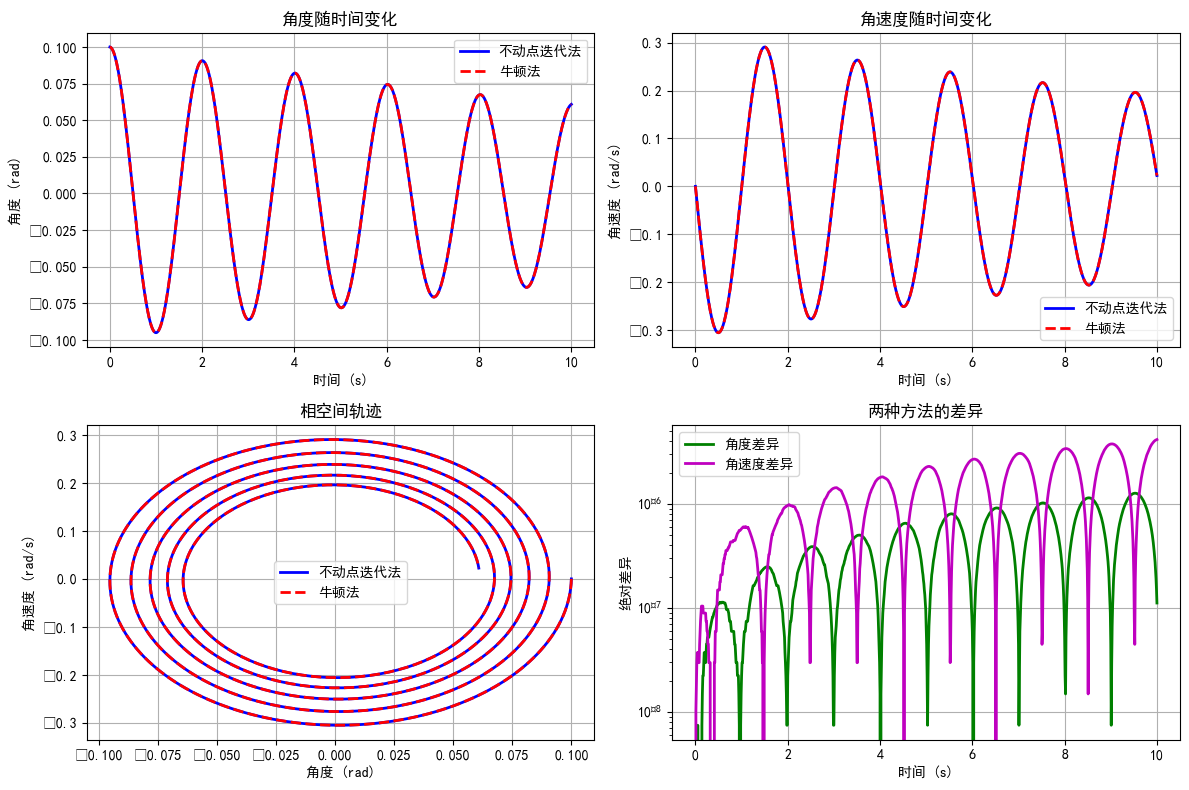

In [9]:

plt.rcParams['font.family'] = 'SimHei'


# 绘制结果对比
plt.figure(figsize=(12, 8))

# 角度对比
plt.subplot(2, 2, 1)
plt.plot(t_hist, x_hist_fp[0, :], 'b-', label='不动点迭代法', linewidth=2)
plt.plot(t_hist, x_hist_newton[0, :], 'r--', label='牛顿法', linewidth=2)
plt.xlabel('时间 (s)')
plt.ylabel('角度 (rad)')
plt.title('角度随时间变化')
plt.legend()
plt.grid(True)

# 角速度对比
plt.subplot(2, 2, 2)
plt.plot(t_hist, x_hist_fp[1, :], 'b-', label='不动点迭代法', linewidth=2)
plt.plot(t_hist, x_hist_newton[1, :], 'r--', label='牛顿法', linewidth=2)
plt.xlabel('时间 (s)')
plt.ylabel('角速度 (rad/s)')
plt.title('角速度随时间变化')
plt.legend()
plt.grid(True)

# 相空间轨迹
plt.subplot(2, 2, 3)
plt.plot(x_hist_fp[0, :], x_hist_fp[1, :], 'b-', label='不动点迭代法', linewidth=2)
plt.plot(x_hist_newton[0, :], x_hist_newton[1, :], 'r--', label='牛顿法', linewidth=2)
plt.xlabel('角度 (rad)')
plt.ylabel('角速度 (rad/s)')
plt.title('相空间轨迹')
plt.legend()
plt.grid(True)

# 差异
plt.subplot(2, 2, 4)
diff = jnp.abs(x_hist_fp - x_hist_newton)
plt.semilogy(t_hist, diff[0, :], 'g-', label='角度差异', linewidth=2)
plt.semilogy(t_hist, diff[1, :], 'm-', label='角速度差异', linewidth=2)
plt.xlabel('时间 (s)')
plt.ylabel('绝对差异')
plt.title('两种方法的差异')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 收敛性分析

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

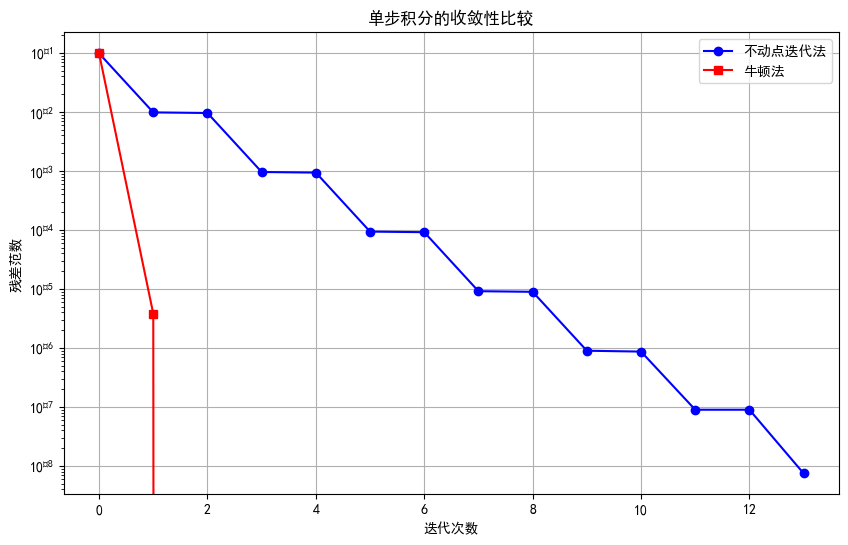

不动点迭代法收敛步数: 14
牛顿法收敛步数: 3


In [10]:
# 单步收敛性分析
x_test = jnp.array([0.1, 0.0])
h_test = 0.1

# 测试两种方法的收敛性
_, errors_fp = backward_euler_step_fixed_point(pendulum_dynamics, x_test, h_test)
_, errors_newton = backward_euler_step_newton(pendulum_dynamics, x_test, h_test)

# 绘制收敛曲线
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors_fp)), errors_fp, 'bo-', label='不动点迭代法', markersize=6)
plt.semilogy(range(len(errors_newton)), errors_newton, 'rs-', label='牛顿法', markersize=6)
plt.xlabel('迭代次数')
plt.ylabel('残差范数')
plt.title('单步积分的收敛性比较')
plt.legend()
plt.grid(True)
plt.show()

print(f"不动点迭代法收敛步数: {len(errors_fp)}")
print(f"牛顿法收敛步数: {len(errors_newton)}")

## 总结

### 方法比较

1. **不动点迭代法**：
   - 实现简单，每次迭代只需要计算一次函数值
   - 收敛速度较慢（线性收敛）
   - 对初值要求较低

2. **牛顿法**：
   - 收敛速度快（二次收敛）
   - 每次迭代需要计算雅可比矩阵，计算量较大
   - 对初值要求较高

### JAX的优势

1. **自动微分**：通过 `jacfwd` 自动计算雅可比矩阵，避免手动推导
2. **JIT编译**：使用 `@jit` 装饰器加速函数执行
3. **向量化操作**：利用JAX的向量化能力提高计算效率
4. **GPU加速**：可以轻松迁移到GPU进行计算

### 应用场景

隐式积分方法特别适用于：
- 刚性微分方程系统
- 需要数值稳定性的长时间仿真
- 最优控制和轨迹优化问题